<a href="https://colab.research.google.com/github/agroimpacts/VegMapper/blob/devel-calval/calval/prepare_train_val_ref_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating a single training/validation/test set from multiple Collect Earth projects

 

### Table of Contents

* [Overview](#overview)
* [Set-up](#setup)
* [Sample preparation](#sample-prep)
    * [Read-in, reshape, and recode](#reshape-recode) 
    * [Simplify the classes](#simplify)
    * [Calculate sample agreement](#agreement)
* [Split the dataset](#split)
    * [Combine and convert to spatial](#combine)
* [Key to variable names](#key)


## Overview <a class="anchor" id="overview"></a>
This notebook demonstrates how several Collect Earth Online projects can be:

1. Recoded and reshaped into a structure more tractable for modeling; 
2. Merged into a single dataset that provide a single label for each sample point and an estimate of label uncertainty;
3. Split into training, validation, and test (or map reference) samples. 

The data used in this demonstration are the results of three Collect Earth Online projects that were captured over the Department of Ucayali, Peru. Each project represents the efforts of an individual (or group of individuals working in the same project) to label 1350 points, classifying each into 1 of 4 classes: not oil palm; young oil palm; mature oil palm;  unsure. The datasets preserve all the information from these projects, although user email addresses were anonymized.

## Sample preparation <a class="anchor" id="sample-prep"></a>
Load packages with messages suppressed.

In [1]:
import pandas as pd
import numpy as np
import re
import random

from google.colab import drive
from datetime import datetime as dt
from pylab import rcParams


In [5]:
## mount your Google Drive to access files
drive.mount('/content/drive')

Mounted at /content/drive


Set Google Drive folder and csv names

In [6]:
googleDriveFolder = 'projects/vegmapper'
csv1 = "ceo-oilpalm_group1.csv"
csv2 = "ceo-oilpalm_group2.csv"
csv3 = "ceo-oilpalm_group3.csv"

Set random seed for splitting data

In [7]:
seed = 999

### Read-in, reshape, and recode classes <a class="anchor" id="reshape-recode"></a>
The first step was to combine the three datasets into a single dataset, with the columns from each of the three CEO projects, and to recode the four classes into a single column with values 0 (not oil palm),  1 (young oil palm), 2 (mature oil palm), 3 (unsure). At this step, we end up with 3 columns, 1 per completed CEO project: `cl1` = samples from project 1, `cl2` = samples from project 2, `cl3` = samples from project 3. Each column contains the recoded classes (note the renaming of the columns is done in the next code chunk). 

In [10]:
## need to import these survey files first (to Files on left)
fs = [csv1, csv2, csv3]

# read datasets into list, keep the most important columns, and do some renaming

def process_csv(csv_path):
  csv_data = pd.read_csv('/content/drive/MyDrive/' + googleDriveFolder + '/' + 
              csv_path, index_col=False)
   
  column_list = ["plotid", "pl_cluster", "email", "center_lon", "center_lat"] 
  column_list_oil = csv_data.filter(regex='Oil').columns.values.tolist()

  csv_data = csv_data[column_list + column_list_oil]
  csv_data = csv_data.rename(columns={"center_lon": "x", "center_lat": "y",
                                       "pl_cluster": "clust", "plotid": "id"})

  csv_data = csv_data.rename(columns=lambda x: re.sub('Oil Palm|\\?\\:| ','',x))

  csv_data['class'] = csv_data.apply(lambda row: 1 if row['Young'] == 100 else -9999,
                            axis = 1)
  csv_data['class'] = csv_data.apply(lambda row: 2 if (row['Mature'] == 100 and row['class'] == -9999) else row['class'] ,
                            axis = 1)
  csv_data['class'] = csv_data.apply(lambda row: 0 if (row['Not'] == 100 and row['class'] == -9999) else row['class'] ,
                            axis = 1)
  csv_data['class'] = csv_data.apply(lambda row: 3 if (row['NotSure'] == 100 and row['class'] == -9999) else row['class'] ,
                            axis = 1)

  csv_data['class'] = csv_data['class'].replace(-9999, np.NaN)
  return(csv_data)

def select_columns(df):
  df = df[['id', 'clust', 'class']]
  return(df)


# Map method returns a map object
# so we cast it into list using list()
data_list_all_columns = list(map(process_csv, fs))
data_list = list(map(select_columns, data_list_all_columns))

#print(data_list_all_columns[0])
#print(data_list[0])


In [11]:
# combine into single dataset, contains just the plot id, the stratum (clust), 
# and the recoded classification columns from each input


sample_combined_1 = pd.merge(data_list[0], data_list[1], how='left', 
                             on=['id', 'clust'], suffixes =(None, '_2'))
sample_combined = pd.merge(sample_combined_1, data_list[2], how='left', 
                           on=['id', 'clust'], suffixes =('_1', '_3'))

sample_combined = sample_combined.rename(
    columns={"class_1": "cl1", "class_2": "cl2", "class_3": "cl3"}
)
#nms[grep("class", nms)] <- paste0("cl", 1:length(grep("class", nms)))
#names(sample_combined) = nms
print(sample_combined)

        id  clust  cl1  cl2  cl3
0        1      1    2    2  NaN
1        2      1    0    0  0.0
2        3      0    0    0  0.0
3        4      1    2    2  1.0
4        5      0    0    0  0.0
...    ...    ...  ...  ...  ...
1345  1346      1    2    3  2.0
1346  1347      0    0    0  0.0
1347  1348      0    0    3  2.0
1348  1349      1    0    0  0.0
1349  1350      0    0    0  0.0

[1350 rows x 5 columns]


### Simplify the classes <a class="anchor" id="simplify"></a>

In this step, a single classification is created by finding the modal class for each sample point across the 3 groups' results. This creates a new `class` column, which provides the class from the majority opinion. 

We repeat this same step again after first collapsing, within each of the `cl1:cl3` columns, the two oil palm classes into a single *oil palm* class with value = 1--*not oil palm* remains 0, and *unsure* remains 3. The modal function was re-run to create a new consensus class, called `class2`. We recommend that `class2` be used for modelling, while `class` may be useful for understanding error patterns. 

In [12]:
# reshape and assign class as most frequently occurring value

samples_red = sample_combined.copy()

## create new "cl_rpl" columns that change values of 2 to 1
samples_red['cl1_rpl'] = samples_red['cl1'].copy()
samples_red.loc[samples_red.cl1 == 2, 'cl1_rpl'] = 1
samples_red['cl2_rpl'] = samples_red['cl2'].copy()
samples_red.loc[samples_red.cl2 == 2, 'cl2_rpl'] = 1
samples_red['cl3_rpl'] = samples_red['cl3'].copy()
samples_red.loc[samples_red.cl3 == 2, 'cl3_rpl'] = 1


## take mode on original cl columns
samples_red['class'] = samples_red[['cl1', 'cl2', 'cl3']]\
    .mode(axis='columns', numeric_only=True).iloc[:, 0]

## take mode on new columns
samples_red['class2'] = samples_red[['cl1_rpl', 'cl2_rpl', 'cl3_rpl']]\
    .mode(axis='columns', numeric_only=True).iloc[:, 0]

#print(samples_red)

timestamp = dt.now().strftime("%Y_%m_%d_%H%M%S")

with open('/content/drive/My Drive/' + googleDriveFolder + \
          '/test_samples_red_' + timestamp + '.csv', 'w') as f:
  samples_red.to_csv(f, float_format='{:f}'.format, encoding='utf-8', 
                     index = False)

print("file exported")

file exported


### Calculate sample agreement <a class="anchor" id="agreement"></a>
The next step was to calculate some agreement metrics across the three groups' samples. The primary approach was to calculate the proportion of labelling teams that selected the modal class. Since there were just three teams in this example, values were either 0.333, 0.667, 1. This agreement was calculated across for both the original classification scheme (class: 0-3) and the simplifed scheme (), with columns `agree` and `agree2` providing the respective proportions for each observation. 

In [13]:

# Python code to count the number of occurrences
def countX(lst, x):
    return lst.count(x)
 

# function to calculate agreement
def agree_func(val, vct):
  vct = [x for x in vct if np.isnan(x) == False]
  agr = countX(vct, val) / len(vct)
  return(agr)


samples_redf = samples_red.copy()


samples_redf['agree'] =  samples_redf.apply(
    lambda row: agree_func(row['class'], [row['cl1'], row['cl2'], row['cl3']]),
    axis = 1
)
samples_redf['agree2'] =  samples_redf.apply(
    lambda row: agree_func(
        row['class2'], [row['cl1_rpl'], row['cl2_rpl'], row['cl3_rpl']]
    ), axis = 1
)
#print(samples_redf)

with open('/content/drive/My Drive/' +\
          googleDriveFolder + '/test_samples_redf_' +\
          timestamp + '.csv', 'w') as f:
  samples_redf.to_csv(f, float_format='{:f}'.format, encoding='utf-8', 
                      index = False)

print("file exported")


file exported


We can then calculate the average agreement per sample to get a sense of the uncertainty in labels for each class, for all 4 classes 

In [14]:
sample_stats = samples_redf.groupby("class").mean() 
sample_stats = sample_stats.rename(columns={"agree": "mean agreement"})
print(sample_stats[['mean agreement']])

       mean agreement
class                
0.0          0.980893
1.0          0.574713
2.0          0.835294
3.0          0.690476


And for the reduced set of classes

In [15]:
sample_stats_2 = samples_redf.groupby("class2").mean() 
sample_stats_2 = sample_stats_2.rename(columns={"agree2": "mean agreement"})
print(sample_stats_2[['mean agreement']])

        mean agreement
class2                
0.0           0.984658
1.0           0.893103
3.0           0.690476


## Split the dataset <a class="anchor" id="split"></a>

Here we split the dataset into three parts for model training (60% of the sample), validation (20%), and final assessment (the 20% set aside as the test or map reference dataset).

The splits are confined to the usable sample, which is defined as samples not falling into class 3 and those with at least 2/3 observers agreeing on the class. This decision is made based on the simplified sample scheme (class2), rather than the full scheme (class). The resulting splits are denoted in a column called `usage` (this is distinct from the column `use`, which was used to filter out unusable observations). 

Values of "unusable" in the `usage` column indicate observations that were not usable because of their low agreement or uncertain class.  They are included here for completeness, and in case they help with evaluation


In [16]:
full_sample = samples_redf.copy()
full_sample['use'] =  full_sample.apply(
    lambda row: 1 if (row['agree2'] > 0.5 and row['class2'] != 3) else 0 ,
    axis = 1
)
full_sample['usage'] = 'NA'

# do a join to get the coordinates for each site
# read back in one of the datasets to get sample id and coordinates 

xy_data = data_list_all_columns[0]


full_sample_merged = full_sample.merge(xy_data, on = 'id', how = 'left', 
                                       suffixes=("", "_y"))

full_sample_merged = full_sample_merged[
    ['id', 'clust', 'use', 'usage', 'class2', 'agree2', 'class', 'agree', 'cl1', 
     'cl2', 'cl3', 'x', 'y']
]

#print(full_sample_merged)

filtered_sample = full_sample_merged[full_sample_merged['use'] == 1]

print(filtered_sample)

        id  clust  use usage  class2    agree2  class     agree  cl1  cl2  \
0        1      1    1    NA     1.0  1.000000    2.0  1.000000    2    2   
1        2      1    1    NA     0.0  1.000000    0.0  1.000000    0    0   
2        3      0    1    NA     0.0  1.000000    0.0  1.000000    0    0   
3        4      1    1    NA     1.0  1.000000    2.0  0.666667    2    2   
4        5      0    1    NA     0.0  1.000000    0.0  1.000000    0    0   
...    ...    ...  ...   ...     ...       ...    ...       ...  ...  ...   
1344  1345      0    1    NA     0.0  1.000000    0.0  1.000000    0    0   
1345  1346      1    1    NA     1.0  0.666667    2.0  0.666667    2    3   
1346  1347      0    1    NA     0.0  1.000000    0.0  1.000000    0    0   
1348  1349      1    1    NA     0.0  1.000000    0.0  1.000000    0    0   
1349  1350      0    1    NA     0.0  1.000000    0.0  1.000000    0    0   

      cl3          x          y  
0     NaN -75.045545  -8.321900  
1     0

In [17]:
## divide filtered data into training, val, ref
train = filtered_sample.sample(frac = 0.6, random_state = seed)

not_train = filtered_sample.drop(train.index)
val = not_train.sample(frac = 0.5, random_state = seed)
ref = not_train.drop(val.index)

train['usage'] = 'train'
val['usage'] = 'validate'
ref['usage'] = 'map reference/test'

# Check for duplicate in each
print('validation check: ', 
      set(val['id']).isdisjoint(set(train['id'])),
      set(ref['id']).isdisjoint(set(train['id'])),
      set(val['id']).isdisjoint(set(ref['id'])))

#print(train)
#print(validate)
#print(ref)


validation check:  True True True


### Combine and export to csv <a class="anchor" id="combine"></a>

The ineligible portion of the sample is also added back for completeness

In [25]:
trainvalref = pd.concat([train, val, ref])
#print(trainvalref[['id', 'clust', 'agree', 'x', 'y']])

valid_ids = trainvalref['id'].values
#print(valid_ids)

omitted_rows = full_sample[~full_sample['id'].isin(valid_ids)].copy()
omitted_rows['usage'] = 'unusable'

full_samplef = pd.concat([trainvalref, omitted_rows])
#print(full_samplef)

## write csv to drive

with open('/content/drive/My Drive/' +\
          googleDriveFolder + '/full_samplef_' + timestamp + '.csv', 'w') as f:
  full_samplef.to_csv(f, float_format='{:f}'.format, encoding='utf-8', 
                      index = False)

print('file exported')

file exported


Here is the count distribution by class and usage

In [26]:
grouped = full_samplef.groupby(['usage','class2'], group_keys=False).count()
grouped = grouped.rename(columns={"id": "count"})
print(grouped[['count']])

                           count
usage              class2       
map reference/test 0.0       196
                   1.0        67
train              0.0       614
                   1.0       173
unusable           0.0         8
                   1.0         2
                   3.0        28
validate           0.0       214
                   1.0        48


And their locations on a map

[1 2 3 4]


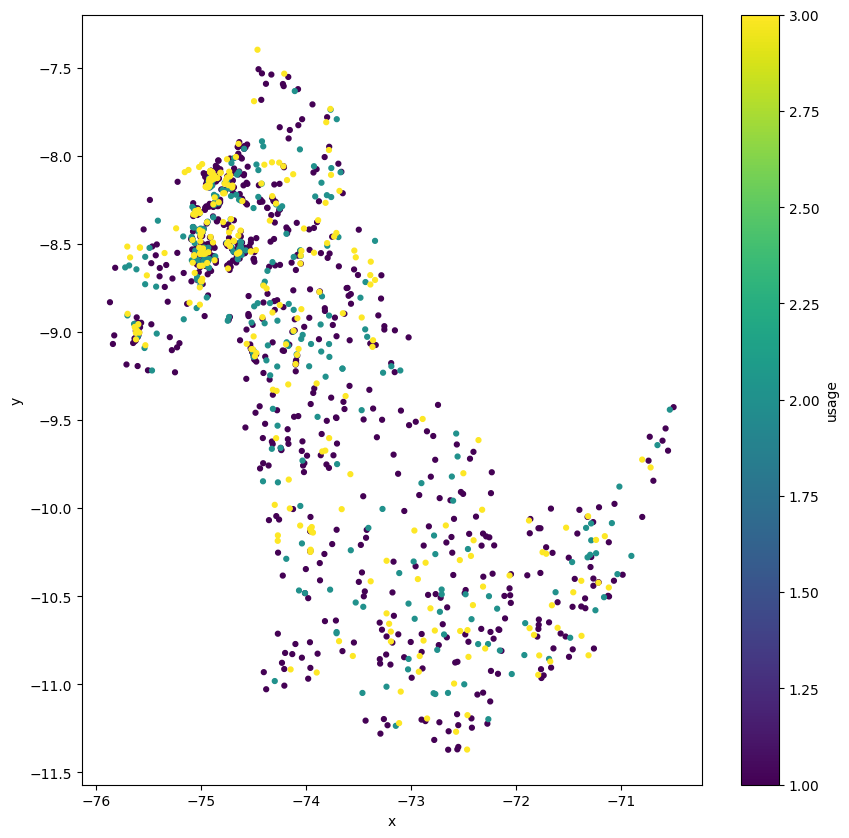

In [28]:
plot_sample = full_samplef.copy()

usage_dict = {'train': 1, 'validate': 2, "map reference/test": 3, "unusable": 4}
plot_sample = plot_sample.replace({'usage':usage_dict})

print(plot_sample['usage'].unique())

rcParams['figure.figsize'] = 10, 10
plot_sample.plot.scatter(x='x', y='y', c='usage', s=12, cmap='viridis')
None

## Key to variable names <a class="anchor" id="key"></a>

The variable names and their descriptions are as follows:

- id = Sample ID (corrected after randomized ordering)
- clust = Stratification cluster (0, 1, 11 [previously digitized areas])
- use = Usability of sample: 1 = suitable for training/validation/map reference, 0 = unusable
- usage = Categorized into training, validation, and map reference (test) splits
- class2: Classification by consensus on simplified oil palm class
- agree2: Agreement per observation, assessed using simplified classification scheme
- class: Consensus classification using all four classes (not recommended for modelling)
- agree: Agreement per observation, assessed using full classification scheme
- cl1: Labeller 1 sample
- cl2: Labeller 2 sample
- cl3: Labeller 3 sample
- geometry: X and Y coordinates as simple features